<a href="https://colab.research.google.com/github/salama4ai/AI-project/blob/main/PyTorch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is for preprocessing the data and implementing the model using Pytorch library

In [16]:
# importing the libraries
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

In [41]:
# this line to select the GPU as an engine for doing the work if it's possible, else it selects the 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# This function to be able to reproduce the same numbers in the future, by fixing
# the algorithms parameters that lead to generate the same random numbers

# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=7
set_random_seed(seed=seed)

In [18]:
x = pd.read_csv("/content/drive/MyDrive/Mabrains-project/Mabrains-data/mabrains.csv")

In [19]:
x.head()

,vds,L(um),W(um),vgs,vsb,corner,id(uA)
0,-0.45,8.0,0.84,0.0,0.0,tt,0.034866
1,-0.40,8.0,0.84,0.0,0.0,tt,0.009451
2,-0.35,8.0,0.84,0.0,0.0,tt,0.002331
3,-0.30,8.0,0.84,0.0,0.0,tt,0.000532
4,-0.25,8.0,0.84,0.0,0.0,tt,0.000111


# Preprocessing

1- i will convert corner column into one hot encoded columns

2- i will apply on W(um) and L(um) columns, to make sure that the high values in these two columns will not dominate the model calculations and thus the model decision just due to containing high values

In [25]:
# separate the output(or label or target) column from the features(input) columns
# where 'x' the feature columns,
# 'y' is the target column
y = x.pop("id(uA)")

# split the train and test sets and the coresponding labels
xtrain_unprocessed, xtest_unprocessed, ytrain, ytest = train_test_split(x, y, test_size=0.21, random_state=seed, shuffle=True)

In [27]:
# apply the needed transformations over the determined columns
col_trans1 = make_column_transformer(("passthrough", ['vgs', 'vds', 'vsb']),
                                    (OneHotEncoder(handle_unknown="infrequent_if_exist"), ['corner']),
                                    (MinMaxScaler(), ['L(um)', 'W(um)']),
                                     remainder="drop",
                                     n_jobs=-1)
xtrain = col_trans1.fit_transform(xtrain_unprocessed)
xtest = col_trans1.transform(xtest_unprocessed)

In [107]:
class CollectedData(Dataset):
    def __init__(self, x, y):
        self.data = torch.tensor(x)
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]


    def __getitem__(self, idx):
        return self.data[idx].float(), self.label[idx].float()

    def __len__(self):
        return self.n_smpl

train_set = CollectedData(xtrain, ytrain)
test_set = CollectedData(xtest, ytest)

In [108]:
## almost the same result of the brevious cell, using another way.
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels = torch.tensor(ytrain.values.astype(np.float32))
# test_labels = torch.tensor(ytest.values.astype(np.float32))
# train_input = torch.tensor(xtrain.values.astype(np.float32))
# test_input = torch.tensor(xtest.values.astype(np.float32))

# train_set = TensorDataset(train_input, train_labels)
# test_set = TensorDataset(test_input, test_labels)


In [139]:
batch_size = 4096

train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)

In [140]:
class network(nn.Module):
    def __init__(self, in_features=10, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 24)
        self.fc2 = nn.Linear(24, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, out_features)
        self.initialize_weights()


    def forward(self, inpt):
        out = F.relu(self.fc1(inpt))
        out = F.relu(self.fc2(out))
        # out = F.leaky_relu(self.fc3(out))
        # out = F.leaky_relu(self.fc4(out))
        # out = F.leaky_relu(self.fc5(out))
        out = ((self.fc6(out)))
        # out = F.softmax((self.fc6(out)), dim=1)
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


In [141]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader=train_loader):
    model.eval()

    num_correct, num_samples = 0, 0

    for data, labels in data_loader:

        # transfering data to cuda
        data = data.to(device=device)
        labels = labels.to(device=device)

        preds = model(data)
        num_correct += sum(list(preds.argmax(dim=1)==labels))
        num_samples += len(labels)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy

In [142]:
# initializing the model
model = network().to(device)
lr = 0.3
# loss and optimizer initializing
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=7, verbose=True)
model

network(
  (fc1): Linear(in_features=10, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
num_epochs = 3
def train_model(num_epochs, data_loader=train_loader):
    num_batches = len(data_loader)
    print(f"""batch_size = {batch_size} \n starting learning rate = {lr} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")

    # starting training loop epochs
    result_train_acc, result_test_acc = [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)
        for batch_idx, (data, labels) in progress:

            # convert data to device
            data = data.to(device=device)
            labels = labels.to(device=device)

            # getting prediction and loss
            preds = model(data)
            loss = criterion(preds, labels)

            # back propagation
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        train_acc = calculate_accuracy(model, data_loader=train_loader)
        test_acc = calculate_accuracy(model, data_loader=test_loader)
        schedular.step(test_acc)
        print(f"after {1+epoch} epoch, train_acc = {train_acc*100:.2f}%, test_acc = {test_acc*100:.2f}%,\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts. \n","-"*199)
        result_train_acc += [train_acc]
        result_test_acc += [test_acc]
        if test_acc==0.1 and train_acc==0.1:
            # schedular.step(test_acc)
            return result_train_acc, result_test_acc
    return result_train_acc, result_test_acc
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader)


batch_size = 4096 
 starting learning rate = 0.3 
 number of epochs = 3    
 number of batches = 169 
 model = network(
  (fc1): Linear(in_features=10, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=1, bias=True)
), 
 criterion=MSELoss(), 
 optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.3
    maximize: False
    weight_decay: 0
)


epoch [1/3], loss=1432221.1250: 100%|██████████| 169/169 [00:26<00:00,  6.30it/s]


after 1 epoch, train_acc = 0.75%, test_acc = 0.74%,        time_elapsed = 0.8 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


epoch [2/3], loss=1338554.2500:  94%|█████████▍| 159/169 [00:25<00:01,  7.60it/s]

In [121]:
print(f"maximun training accuracy={(max(result_train_acc)):.2f}%\nmaximun test accuracy={(max(result_test_acc)):.2f}%")

maximun training accuracy=0.01%
maximun test accuracy=0.01%


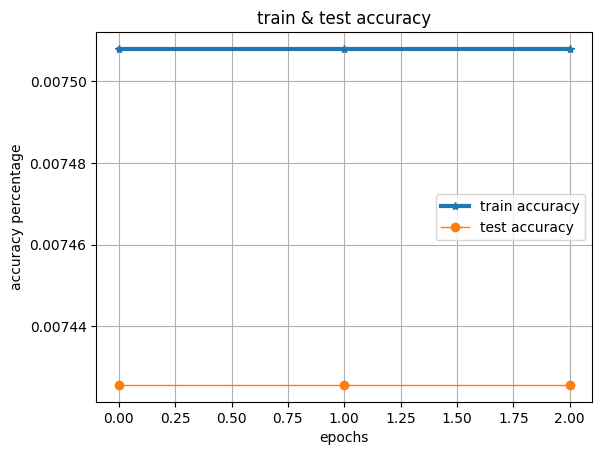

In [122]:
train_line_val = np.array([val.cpu() for val in result_train_acc]) # just replace val with val.cpu() if output is cuda
test_line_val = np.array([val.cpu() for val in result_test_acc]) # just replace val with val.cpu() if output is cuda

train_line, = plt.plot((range(len(train_line_val))), train_line_val, label="train accuracy", marker="*", linewidth=3)
test_line, = plt.plot((range(len(test_line_val))), test_line_val, label="test accuracy", marker="o", linewidth=1)
plt.legend(loc="best", handles=[train_line, test_line])
plt.title("train & test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.grid()
plt.show()

In [123]:
linear_regressor = LinearRegression(random_state=seed, n_estimators=1000, verbose=1)
pipe = make_pipeline(col_trans1, l_regressor)

param_grid={

}
search = GridSearchCV(pipe, param_grid, cv=5, )
search.fit(xtrain, ytrain)
search.best_score_

TypeError: ignored